### Import libraries

In [1]:
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from datetime import datetime
logdir = "./logs_DAEwithValData/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, restore_best_weights=True)

A couple of methods to see local compute devices

In [2]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 70768890627195935
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1482142514
locality {
  bus_id: 1
  links {
  }
}
incarnation: 13859863658317963147
physical_device_desc: "device: 0, name: Quadro M2000M, pci bus id: 0000:01:00.0, compute capability: 5.0"
]


In [3]:
physical_devices = tf.config.list_physical_devices()
physical_devices

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
#tf.config.set_visible_devices(physical_devices[1:],'GPU')

Following are different options to check if GPU is being used by tensorflow

In [5]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [6]:
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Quadro M2000M, pci bus id: 0000:01:00.0, compute capability: 5.0



In [7]:
tf.test.is_gpu_available( cuda_only=False, min_cuda_compute_capability=None)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

### Load MNIST data
Load and split data to train, validation and test sets

In [8]:
(X_train, _), (X_test, _) = mnist.load_data()

In [9]:
X_train[0,:,:].shape

(28, 28)

In [10]:
X_val = X_train[-10000:,:,:]
X_train = X_train[:-10000,:,:]

In [11]:
X_train.shape, X_val.shape

((50000, 28, 28), (10000, 28, 28))

### Scale pixel data to a uniform range
Pixel values can range from 0 to 255 and scaling can bring them to [0,1] range

In [12]:
X_train = X_train.astype('float32')/255.
X_val = X_val.astype('float32')/255.
X_test = X_test.astype('float32')/255.

X_train = np.reshape(X_train, (len(X_train),28,28,1))
X_val = np.reshape(X_val, (len(X_val),28,28,1))
X_test = np.reshape(X_test, (len(X_test),28,28,1))

In [13]:
X_train.shape, X_val.shape, X_test.shape

((50000, 28, 28, 1), (10000, 28, 28, 1), (10000, 28, 28, 1))

### Introduce noise in data
Noise from a normal distribution with suitable mean and standard deviation may be introduced for robust learning

In [14]:
X_train_noisy = X_train + 0.5 * np.random.normal(loc=0.0,scale=1.0,size=X_train.shape)
X_val_noisy = X_val + 0.5 * np.random.normal(loc=0.0,scale=1.0,size=X_val.shape)
X_test_noisy = X_test + 0.5 * np.random.normal(loc=0.0,scale=1.0,size=X_test.shape)

X_train_noisy = np.clip(X_train_noisy,0.,1.)
X_val_noisy = np.clip(X_val_noisy,0.,1.)
X_test_noisy = np.clip(X_test_noisy,0.,1.)

### Visualize validation and test samples

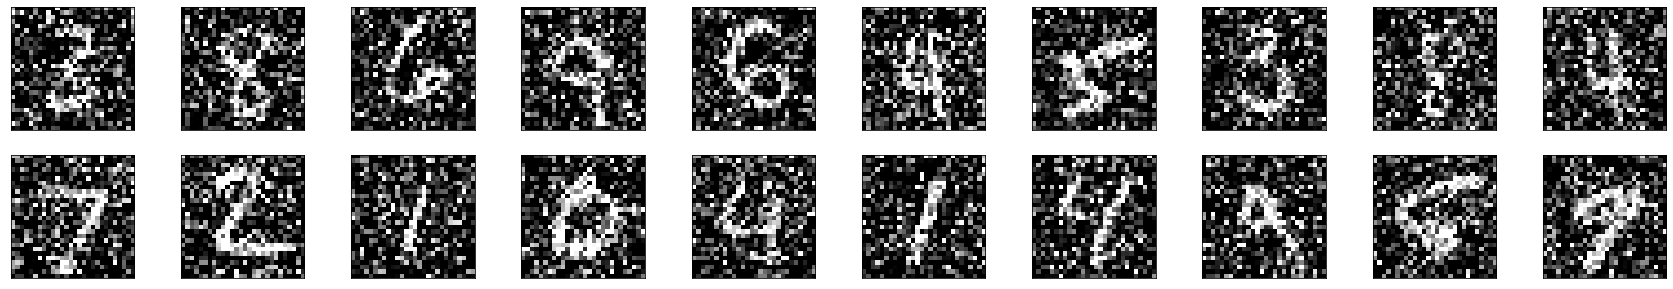

In [15]:
n = 10
plt.figure(figsize=(30,5))
for i in range(n):
    ax = plt.subplot(2,n,i+1)
    plt.imshow(X_val_noisy[i].reshape((28,28)))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(2,n,i+1+n)
    plt.imshow(X_test_noisy[i].reshape((28,28)))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### Build and compile convolutional autoencoder
A 2-layer encoder and decoder with convolutional and max pooling layers, compiled with binary cross entropy and adadelta optimizer

In [16]:
input_image = tf.keras.layers.Input(shape=(28,28,1))
x = tf.keras.layers.Conv2D(32,(3,3), activation='relu', padding='same')(input_image)
x = tf.keras.layers.MaxPool2D((2,2), padding='same')(x)
x = tf.keras.layers.Conv2D(32,(3,3), activation='relu', padding='same')(x)
encoded = tf.keras.layers.MaxPool2D((2,2), padding='same')(x)
x = tf.keras.layers.Conv2D(32,(3,3), activation='relu', padding='same')(encoded)
x = tf.keras.layers.UpSampling2D((2,2))(x)
x = tf.keras.layers.Conv2D(32,(3,3), activation='relu', padding='same')(x)
x = tf.keras.layers.UpSampling2D((2,2))(x)
decoded = tf.keras.layers.Conv2D(1,(3,3), activation='sigmoid', padding='same')(x)

In [17]:
autoencoder = tf.keras.models.Model(input_image, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 32)          9248      
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 14, 14, 32)        0     

### Train the model 
Number of iterations, batch size and validation data can be set here

In [18]:
history = autoencoder.fit(X_train_noisy, X_train, 
                          epochs = 250 , batch_size = 128, 
                          shuffle =  True, 
                          validation_data = (X_val_noisy,  X_val),
                          callbacks=[es, tensorboard_callback])

Epoch 1/250
391/391 [==============================] - 14s 29ms/step - loss: 0.6817 - val_loss: 0.6712
Epoch 2/250
391/391 [==============================] - 10s 25ms/step - loss: 0.6558 - val_loss: 0.6351
Epoch 3/250
391/391 [==============================] - 10s 26ms/step - loss: 0.6030 - val_loss: 0.5618
Epoch 4/250
391/391 [==============================] - 10s 25ms/step - loss: 0.5301 - val_loss: 0.5065
Epoch 5/250
391/391 [==============================] - 10s 25ms/step - loss: 0.5036 - val_loss: 0.4951
Epoch 6/250
391/391 [==============================] - 10s 25ms/step - loss: 0.4949 - val_loss: 0.4871
Epoch 7/250
391/391 [==============================] - 10s 25ms/step - loss: 0.4867 - val_loss: 0.4790
Epoch 8/250
391/391 [==============================] - 10s 26ms/step - loss: 0.4783 - val_loss: 0.4705
Epoch 9/250
391/391 [==============================] - 10s 25ms/step - loss: 0.4692 - val_loss: 0.4612
Epoch 10/250
391/391 [==============================] - 10s 25ms/step - l

Epoch 80/250
391/391 [==============================] - 10s 25ms/step - loss: 0.1560 - val_loss: 0.1573
Epoch 81/250
391/391 [==============================] - 10s 25ms/step - loss: 0.1556 - val_loss: 0.1569
Epoch 82/250
391/391 [==============================] - 10s 25ms/step - loss: 0.1553 - val_loss: 0.1565
Epoch 83/250
391/391 [==============================] - 10s 25ms/step - loss: 0.1549 - val_loss: 0.1562
Epoch 84/250
391/391 [==============================] - 10s 25ms/step - loss: 0.1545 - val_loss: 0.1558
Epoch 85/250
391/391 [==============================] - 10s 25ms/step - loss: 0.1542 - val_loss: 0.1555
Epoch 86/250
391/391 [==============================] - 10s 25ms/step - loss: 0.1538 - val_loss: 0.1551
Epoch 87/250
391/391 [==============================] - 10s 25ms/step - loss: 0.1535 - val_loss: 0.1548
Epoch 88/250
391/391 [==============================] - 10s 25ms/step - loss: 0.1532 - val_loss: 0.1545
Epoch 89/250
391/391 [==============================] - 10s 25ms

391/391 [==============================] - 10s 25ms/step - loss: 0.1380 - val_loss: 0.1392
Epoch 159/250
391/391 [==============================] - 10s 25ms/step - loss: 0.1379 - val_loss: 0.1390
Epoch 160/250
391/391 [==============================] - 10s 25ms/step - loss: 0.1377 - val_loss: 0.1389
Epoch 161/250
391/391 [==============================] - 10s 25ms/step - loss: 0.1376 - val_loss: 0.1387
Epoch 162/250
391/391 [==============================] - 10s 25ms/step - loss: 0.1374 - val_loss: 0.1386
Epoch 163/250
391/391 [==============================] - 10s 25ms/step - loss: 0.1373 - val_loss: 0.1384
Epoch 164/250
391/391 [==============================] - 10s 25ms/step - loss: 0.1372 - val_loss: 0.1383
Epoch 165/250
391/391 [==============================] - 10s 25ms/step - loss: 0.1370 - val_loss: 0.1382
Epoch 166/250
391/391 [==============================] - 10s 25ms/step - loss: 0.1369 - val_loss: 0.1380
Epoch 167/250
391/391 [==============================] - 10s 25ms/ste

391/391 [==============================] - 10s 25ms/step - loss: 0.1302 - val_loss: 0.1312
Epoch 237/250
391/391 [==============================] - 10s 25ms/step - loss: 0.1301 - val_loss: 0.1311
Epoch 238/250
391/391 [==============================] - 10s 25ms/step - loss: 0.1300 - val_loss: 0.1311
Epoch 239/250
391/391 [==============================] - 10s 25ms/step - loss: 0.1300 - val_loss: 0.1310
Epoch 240/250
391/391 [==============================] - 10s 25ms/step - loss: 0.1299 - val_loss: 0.1309
Epoch 241/250
391/391 [==============================] - 10s 25ms/step - loss: 0.1299 - val_loss: 0.1308
Epoch 242/250
391/391 [==============================] - 10s 25ms/step - loss: 0.1298 - val_loss: 0.1308
Epoch 243/250
391/391 [==============================] - 10s 25ms/step - loss: 0.1297 - val_loss: 0.1307
Epoch 244/250
391/391 [==============================] - 10s 25ms/step - loss: 0.1297 - val_loss: 0.1307
Epoch 245/250
391/391 [==============================] - 10s 25ms/ste

### Visualize the input and output for test data

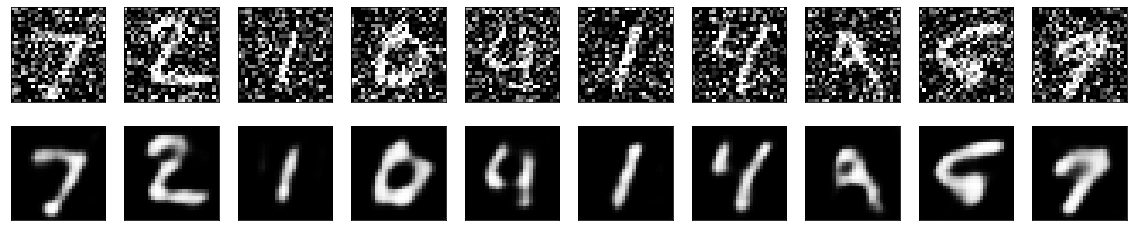

In [19]:
decoded_imgs = autoencoder.predict(X_test_noisy)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n,  i +  1)
    plt.imshow(X_test_noisy[i].reshape(28,28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(2,  n  , i +1 + n)
    plt.imshow(decoded_imgs[i].reshape(28,28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()